In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6) # set default figure size, 8in by 6in

# Video W1 05: Model Representation

[YouTube Video Link](https://www.youtube.com/watch?v=PBZUjnGuXjA&index=5&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

## Some Examples and Notation

In [2]:
house = pd.read_csv('../data/housing-prices-portland-or.csv')
house = house[house.sqft < 3000]   # in video, we only used the houses less than 3000 sq ft
house.price = house.price / 1000.0 # in video, we specify prices in terms of 1000s of dollars

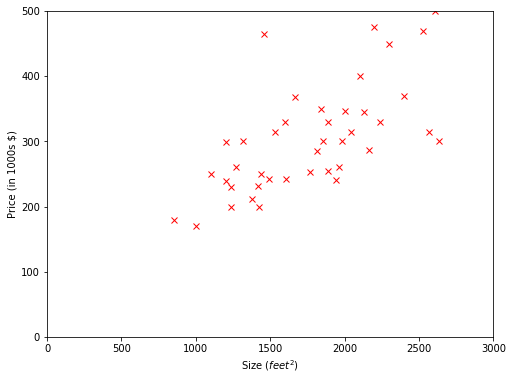

In [3]:
plt.plot(house.sqft, house.price, 'rx')
plt.axis([0, 3000, 0, 500])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)')

Lets show an example of using some built in Python methods to fit a line to the data.  Here we use
the `NumPy` library to fit a polynomial to the data, in this case a straight line.

In [4]:
coef = np.polyfit(house.sqft, house.price, 1) # fit a line (degree 1 polynomial) to the data
hypothesis = np.poly1d(coef)

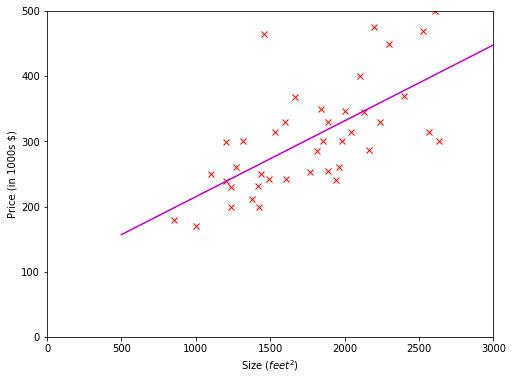

In [5]:
size = np.arange(500, 3000, 1) # ask model to predict prices for all sizes from 500 to 3000 sq ft
estimated_price = hypothesis(size)

# replot raw data
plt.plot(house.sqft, house.price, 'rx')
plt.axis([0, 3000, 0, 500])
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price (in 1000s $)')

#Overlay the fitted model
plt.plot(size, estimated_price, 'm-')

In [7]:
# what is the estimate of model for house of size 1250 square feet?
# about 243k, given our data
print(hypothesis(1250))

244.194074015


In the course, we will be following the standard notation used in the ML community and in our course
videos.  

- $\mathbf{m}$ = Number of training examples
- $\mathbf{x}$'s = "input" variable / feature
- $\mathbf{y}$'s = "output" variable / "target" variable

In our training set data, we have the following for m, x, y

In [9]:
# note that there are 47 training examples in the full data set, but we filtered out
# houses bigger than 3000 sqft, and ended up with only 41 that we plotted
m = len(house) 
print("Number of training examples: ", m)

# an example of converting from a pandas data frame to a numpy matrix/array
# this will be useful later...
x = house.sqft.as_matrix() 
print(x)
y = house.price.as_matrix()
print(y)


Number of training examples:  41
[2104 1600 2400 1416 1985 1534 1427 1380 1494 1940 2000 1890 1268 2300 1320
 1236 2609 1767 1888 1604 1962 1100 1458 2526 2200 2637 1839 1000 2040 1811
 1437 1239 2132 2162 1664 2238 2567 1200  852 1852 1203]
[ 399.9    329.9    369.     232.     299.9    314.9    198.999  212.
  242.5    239.999  347.     329.999  259.9    449.9    299.9    199.9
  499.998  252.9    255.     242.9    259.9    249.9    464.5    469.     475.
  299.9    349.9    169.9    314.9    285.9    249.9    229.9    345.     287.
  368.5    329.9    314.     299.     179.9    299.9    239.5  ]


Given we have assigned the training input sizes to the `x` variable and the training output
prices to the `y` variable, we can access the ith training item using array indexing.  Recall
that in the videos, we will be using the notation:

$$( x^{(i)}, y^{(i)} )$$

as explained, this is not meant to representing raising to a power.  This means we want the ith elements
of the `x` and `y` vectors.  We can get the ith element from the numpy arrays using array indexing:

In [10]:
# arrays are indexed starting at 0 in python, just as an example lets get the items at index 5
i = 5 

# display the ith input and the ith output, if you look on the previous
# plots you should see this plot pointed in the figure as an x
print(x[i], y[i]) 

1534 314.9


**NOTE:** Be careful with indexing.  In the videos, and in math, indexes start at 1.  But in many
programming languages, including Python, indexing into arrays and vectors begin at 0.  Thus the
first element is actually at index 0, and the second at index 1, etc:

In [11]:
print(x[0])
print(x[1])
print(y[0])
print(y[1])

2104
1600
399.9
329.9


## How do we represent h?

In the video, some hypothesis or model $\theta$ is defined to be represented as:

$$h_\theta(x) = \theta_0 + \theta_1x$$

When we used the numpy `polyfit` function, we were basically fitting a straight line to the data, and 
this line represents a model, or a hypothesis, of the relationship of the size to the cost of the house
that we should predict.  The coefficients we returned from calling the `polyfit` function represent
the slope and intercept of the straight line that best fit the data.  In the video, these coefficients
are represented as $\theta_0$ (the intercept) and $\theta_1$ (the slope) for the line.  In future,
we will probably use a variable name of theta to hold these coefficients:

In [12]:
theta = np.polyfit(house.sqft, house.price, 1)
print(theta[0], theta[1])

0.116296798317 98.8230761191


Using `polyfit` the intercept is actually at index 1, and the slope is in index 0, so this is different
from what is shown on the slides, but these are basically the coefficients we are talking about.

For example, the hypothesis, or model estimate, for some size house, say 1250 square feet, can be
found using `numpy`, or by hand, like this:

In [14]:
x_0 = 1.0
x_1 = 1250
hypothesis = np.poly1d(theta)
print(hypothesis(size))

print(x_0 * theta[1] + x_1 * theta[0])

244.194074015
244.194074015


$$
\displaystyle
\sum_{i=1}^{n} x^2
$$

# Video W1 06: Linear Regression with One Variable (Cost Function)

[YouTube Video Link](https://www.youtube.com/watch?v=EANr4YttXIQ&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=6)

# How to choose paramters

Previously we used a built in `numpy` method to choose the $\theta$ parameters for us for our
hypothesis.  Now we will see how this is actually done algorithmically.

We do this by formulating the problem in terms of a minimization.  So the idea is, for some set
of parameters $\theta$ that is a hypothesis, we can define a cost function:

$$
cost = (h_\theta(x) - y)^2
$$

The cost function is simply stating that we take the difference between our hypothesis or model
$h_\theta(x)$ and the actual output $y$, and then we square this difference.

This cost is only in terms of 1 particular input value $x$.  As stated in the video, if we want to
know the overall cost, which is a measure of how well the $\theta$ parameters work as our model,
we need to sum up the cost over all of the input training patterns:

$$
cost = \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2
$$

And as stated in the video, we multiply this cost by $\frac{1}{2m}$ for reasons we will talk about later.
To recap this video then, the goal is to find some value for $\theta_0$ and $\theta_1$ such that the
calculated total cost is the minimum for any possible values of the $\theta$ parameters.

By convention, we use the notation $J$ for the cost function, and write it as:

$$
J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2
$$

This function is commonly known as the squared error cost function (also sometimes called the squared
difference).

# Video W1 XX: Linear Regression with One Variable (Cost function intuition 1)

**NOTE:** This video is missing from youtube.  Here is an alternative link:

[Alternate Video Link Cost Function intuition 1](https://www.youtube.com/watch?v=oeDewhKxnRw)


## Building intuition about the cost function

Lets recap.  Here are our hypothesis, model parameters, cost function, and optimization objectives:

**Hypothesis:** $h_\theta(x) = \theta_0 + \theta_1x$

**Parameters:** $\theta_0, \theta_1$

** Cost Function:** 
$$J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2$$

**Goal:** 
$$\genfrac{}{}{0}{}{\textrm{minimize}}{\theta_0, \theta_1} \;\; J(\theta_0, \theta_1)$$

# Simplified Definition

In order to build up to understanding how minimization of cost functions work, lets simply our problem.
Lets work on minimizing the set of models where we always choose the intercept paramter to be through
the origin, e.g. $\theta_0 = 0$.  If we do this, then our simplified minimization problem we are working
on is:

**Hypothesis:** $h_\theta(x) = \theta_1x$

**Parameters:** $\theta_1$

** Cost Function:** 
$$J(\theta_1) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2$$

**Goal:** 
$$\genfrac{}{}{0}{}{\textrm{minimize}}{\theta_1} \;\; J(\theta_1)$$

Lets write a little function to calculate the cost function $J$ for a single parameter
$\theta_1$ as shown in this video.  We will first define the simple x input values, and
y output values as:

In [15]:
x = np.array([1, 2, 3])
y = np.array([1, 2, 3])

Now lets write a small function in Python to calculate the sum squared cost, given a particular hypothesis
$\theta_1$.  This function assumes that the training inputs $x$ and outputs $y$ are already defined
outside of the function, and simply accepts a single parameter, theta1, as a function parameter:

In [16]:
def cost_function(theta1):
    """Given a theta1 parameter for our simplified hypothesis h(x) = theta1 * x,
    calculate the sum squared difference cost function.  This function assumes that
    the training inputs are in a variable called x, and the correct outputs are in
    a variable called y, defined outside of this function"""
    m = len(x) # training set size
    sum = 0.0  # calculate the running sum squared error
    
    for i in range(0, m):
        sum += ((theta1 * x[i]) - y[i])**2.0
        
    return (1.0 / (2.0 * m)) * sum

Now as shown in the video, lets see what cost we get for a $\theta_1$ of 1, 0.5, 0.0, etc:

In [17]:
print(cost_function(1.0))
print(cost_function(0.5))
print(cost_function(0.0))
print(cost_function(-0.5))
print(cost_function(1.5))
# etc.

0.0
0.583333333333
2.33333333333
5.25
0.583333333333


Lets show the visualization of how the simplified cost function changes as a function of our $\theta_1$
parameter.  To do this, we are first going to digress into a very important topic, the idea of performing
vectorized operations, and writing a vectorized Python function.  Our cost function is actually a
(poorly written, but more on that later) vectorized function.  Vectorized function in this context
means that the function will accept a vector (a `numpy` array) of theta values, and it will compute
and retun an array of the costs for each of the theta parameters.  For example:


In [18]:
theta = np.arange(-0.5, 3.0, 0.5)
print(theta)
print(cost_function(theta))

[-0.5  0.   0.5  1.   1.5  2.   2.5]
[ 5.25        2.33333333  0.58333333  0.          0.58333333  2.33333333
  5.25      ]


How is our function doing this?  This works because numpy arrays work such that operations between arrays,
such as addition and multiplication, are vectorized to work on multiple values simultaneously.

Take for example multiplying theta parameters by the input values x for the 0th input.
If we do this step by hand, we get:

In [19]:
theta * x[0]

array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5])

These represent the hypothesis for input 0 that we are making.  This is an example of a vector operation
where we multiple a scalar value (`x[0]` is a simple floating point value) by a vector.

Likewise the subtraction of this array of values from the `y` output values is a vector operation:

In [20]:
theta * x[0] - y[0]

array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5])

Also, raising a numpy array of values to a power is a vector operation:

In [21]:
(theta * x[0] - y[0])**2.0

array([ 2.25,  1.  ,  0.25,  0.  ,  0.25,  1.  ,  2.25])

These are the operations that are performed inside of the loop in the function.  Notice that this loop
loops over all of the training input/output pairs, from 0 to `m`.  We will later show how to eliminate
this explicit loop using linear algebra matrix operations.

However, given that we can calculate the cost function for many different $\theta_1$ parameters, we can
reproduce the visualization of how the cost varies as a function of $\theta_1$ for our simplified
hypothesis:

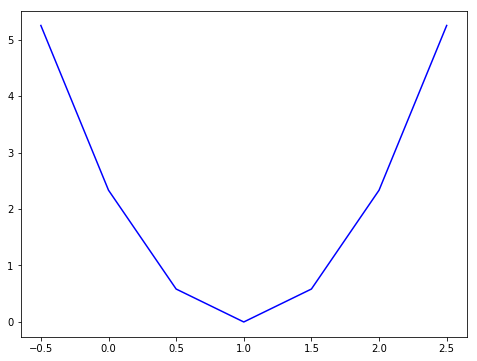

In [22]:
plt.plot(theta, cost_function(theta), 'b-')


Whenever you are performing discrete vectorized calculations, you can end up with jagged plots like this
if you don't investigate your function with enough resolution.  The cost function is actually a smooth
function.  We can get a better feel for the true shape of the cost function by plotting more points in
the range that we want to visualize:

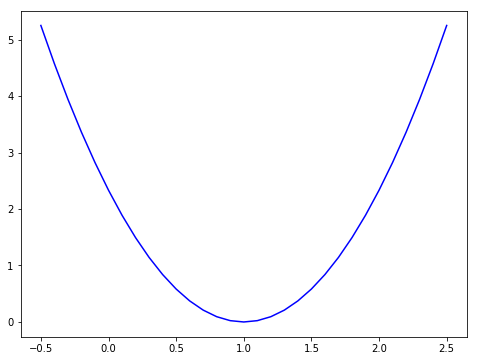

In [23]:
theta = np.arange(-0.5, 2.6, 0.1) # theta1  parameters from -0.5 to 2.5 in 0.1 increments
plt.plot(theta, cost_function(theta), 'b-')


# Video W1 07: Linear Regression with One Variable (Cost function intuition 2)


[YouTube Video Link](https://www.youtube.com/watch?v=J5vJFwQWOaY&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=7)


## Cost Function of Two Parameters

We are now going to expand the simplification of our cost function description to include two parameters of $\theta$.
As a reminder, the hypothesis, cost function and goal when we expand too consider two parameters needed to fit a straight
line to the data give us the following:

**Hypothesis:** $h_\theta(x) = \theta_0 + \theta_1x$

**Parameters:** $\theta_0, \theta_1$

** Cost Function:** 
$$J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} \big(h_\theta(x^{(i)}) - y^{(i)} \big)^2$$

**Goal:** 
$$\genfrac{}{}{0}{}{\textrm{minimize}}{\theta_0, \theta_1} \;\; J(\theta_0, \theta_1)$$


Let us expand our previous vectorized cost function to accept two $\theta$ parameters.  The way this function will work is that
each corresponding value of theta will represent a pair of parameters, $\theta_0, $theta_1$, and the resulting array will give
the cost for each pair of parameters.  An example in code might be easier to understand:

In [24]:
# as before, this function assumes that x and y are already defined outside of the 
# function.  Lets switch over to using the Portland house price data, as is done in this video
x = house.sqft.as_matrix()
y = house.price.as_matrix()

def cost_function_2(theta0, theta1):
    """Given theta0 and theta1 parameters for our hypothesis h(x) = theta0 + theta1 * x,
    calculate the sum squared difference cost function.  This function assumes that
    the training inputs are in a variable called x, and the correct outputs are in
    a variable called y, defined outside of this function"""
    m = len(x) # training set size
    sum = 0.0  # calculate the running sum squared error
    
    for i in range(0, m):
        sum += ((theta0 + theta1 * x[i]) - y[i])**2.0
        
    return (1.0 / (2.0 * m)) * sum

In [27]:
# some examples of pairs of theta parameters, as discussed in the video
theta0 = np.array([50, 80, 200, 98.8])
theta1 = np.array([0.06, 0.1, 0.03, 0.11])

print(cost_function_2(theta0, theta1))

[ 13185.42975862   3042.83715862   3978.97232691   1949.86733179]


## Contour Plots

Lets use our cost function to reproduce the contour plot from the video.  The lecturer
in the video calls all of these contour plots, but in matplotlib, the first more 3d plots are
usually called surface plots.  We need to create two arrays
called theta0 and theta1 in python.  As shown in the video, we want both values to vary from -20
up to 10.  And we want all combinations to occur, so for example when theta0 is -20, we need to 
generate many examples for theta1 ranging from -20 to 10, then for then theta0 is -19, etc.
We can use the `numpy` function `meshgrid` to create all of these combinations for us.  This
function is specially designed for making contour plots like this one (an example of 
the `meshgrid` function and contour plots was given in Lecture 2b on matplotlib).

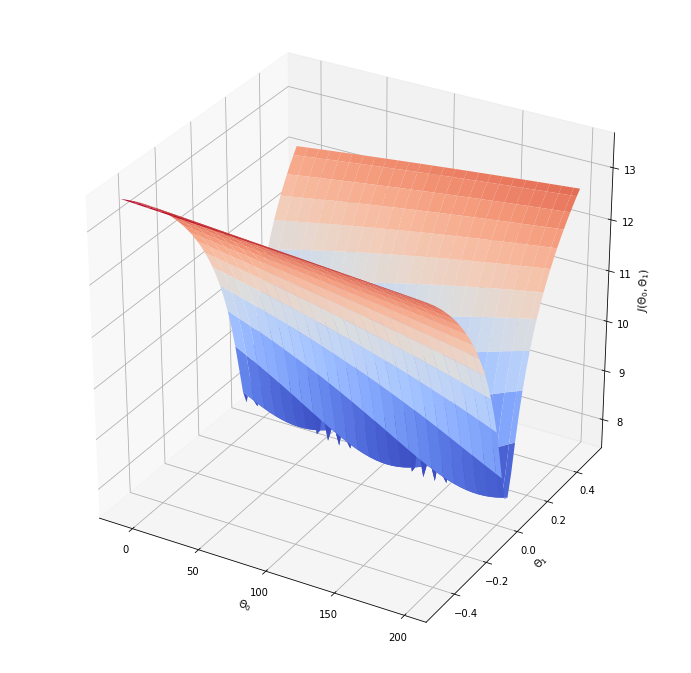

In [29]:
# create the theta0, theta1 combinations
t0 = np.linspace(-10, 200, 50)
t1 = np.linspace(-0.5, 0.5, 50)
theta0, theta1 = np.meshgrid(t0, t1)

cost = cost_function_2(theta0, theta1)


# create the contour plot
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1, projection='3d')
p = ax.plot_surface(theta0, theta1, np.log(cost), rstride=2, cstride=2, cmap=plt.cm.coolwarm)
#ax.view_init(0,0) # change this to rotate the view
ax.set_xlabel('$\Theta_0$')
ax.set_ylabel('$\Theta_1$')
ax.set_zlabel('$J(\Theta_0, \Theta_1)$')

This figure does not exactly look like the figure in the lecture video.  I believe the lecture video is only using an idealized
surface plot, in order to better illustrate the bowl shape of the function in 3 dimensions.  In the surface plot we have displayed
here, we have used the actual cost function of our training data, though we have plotted the log of the cost function, so that we
can better see the shape.  The figure is a bit irregular, but there is a deep valley that you can see, leading down to the minimum
cost point for this data.  You should try rotating the view to different positions, so that you can better visualize the cost
function of the two parameters.

# (Real) Contour Plots

Lets now recreate the actual contour plots.  The following example is very important in building your
intuition between the relationship between a fitted hypothesis / model, and the cost function.

The next cell has a lot of code in it.  It basically recreates the side by side plots, showing the data with a
fitted hypothesis on the left plot, and a contour plot with the hypothesis theta parameters indicated.

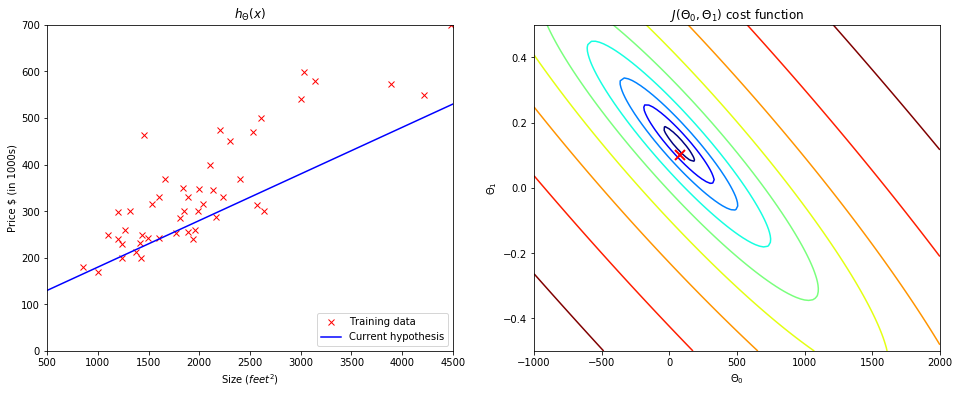

In [32]:
# change these in order to see how the hypothesis changes and the cost function changes
# as a function of the theta0 and theta1 parameters
theta0 = 80.0
theta1 = 0.1

# load the full 47 item data set again
house = pd.read_csv('../data/housing-prices-portland-or.csv')
house.price = house.price / 1000.0 # rescale price in 1000s of $
x = house.sqft.as_matrix()
y = house.price.as_matrix()

# set up figure
fig = plt.figure(figsize=(16,6))

### LEFT subplot
# show training data as scatter plot and show a fitted hypothesis for a given
# hypothesis theta0, theta1
plt.subplot(1, 2, 1)
plt.plot(x, y, 'rx', label='Training data')

# display line representing the theta0, theta1 hypothesis
model_x = np.linspace(0, 4500, 100)
hypothesis_y = theta0 + theta1 * model_x
plt.plot(model_x, hypothesis_y, 'b-', label='Current hypothesis')

plt.axis([500, 4500, 0, 700])
plt.legend(loc=4)
plt.xlabel('Size ($feet^2$)')
plt.ylabel('Price $ (in 1000s)')
plt.title('$h_\Theta(x)$')

### RIGHT subplot
# show contour plot of the cost function J
plt.subplot(1, 2, 2)
t0 = np.linspace(-1000, 2000, 100)
t1 = np.linspace(-0.5, 0.5, 100)
T0, T1 = np.meshgrid(t0, t1)
cost = cost_function_2(T0, T1)

p = plt.contour(T0, T1, np.log(cost), 10, cmap=plt.cm.jet)

#cb = fig.colorbar(p, shrink=0.8) # uncomment if you want to see colorbar showing log value of the cost
plt.xlabel('$\Theta_0$')
plt.ylabel('$\Theta_1$')

# plot the location of theta0, theta1 on the contour plot
plt.plot(theta0, theta1, 'rx', ms=10.0, mew=2.0)
plt.title('$J(\Theta_0, \Theta_1)$ cost function')

You should try various values of theta0 and theta1 in the previous cell and make sure you understand the relationship between
the hypothesis and the cost functions.  Try and minimize the cost function by hand.  You know you have minimized the cost function
when you get the `X` at the bottom of the bowl defined by the contour plot.

# Video W1 08: Gradient Descent 1


[YouTube Video Link](https://www.youtube.com/watch?v=P3K38HusyV4&index=8&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)


## Gradient Descent Algorithm

1. Start with some initial $\theta_0, \theta_1$.

2. Keep changing $\theta_0, \theta_1$ in ways that always reduce $J(\theta_0, \theta_1)$

In mathematical / pseudocode notation:

`repeat until convergence` 
{

$$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta_0, \theta_1) $$

}

Where $\alpha$ is a learning rate parameter, and the $:=$ represents an assignment operator, where
we assign the new value of $\theta_j$ each step using the equation on the right hand side.  Also
make sure that you correctly update all of the $\theta$ parameters simultaneously, as discussed
in the video.


# Video W1 09: Gradient Descent 2


[YouTube Video Link](https://www.youtube.com/watch?v=4SVqZaY55qo&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=9)


## Using the Derivative to make small steps that reduce the cost function

The derivative is the slope of the line tangent to some point of the function.  The slope at some
point gives us a measure of the rate of change of the function (how fast it is changing).  Also, the
sign of the derivative tells us in which direction the function is increasing, and in which it is
decreasing.  So in short, the sign of the derivative lets us know which direction we should go to
cause the function to be reduced, which is very handy when we are trying to minimize a function.

Besides intiutively understanding how the derivative allows us to minimize the function, also make sure
you understand the discussion about the learning rate.  In short, for the gradient descent algorithm,
the learning rate constrains the steps we take so that they are neither too small, nor too large such
that we end up not converging on the minimum.

# Video W1 10: Gradient Descent for Linear Regression


[YouTube Video Link](https://www.youtube.com/watch?v=ns8apGrLhaY&index=10&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW)

## Deriving the Partial Derivative Term

This lecture video gives some more details on deriving the partial derivative terms that are essential
to implement the gradient descent algorithm.  You should try and understand the derivation given in
the video, but ultimately if you are a little fuzzy, it will be ok if you at least understand the final
definations of the derivativies, that we will use to implement the gradient descent algorithm.


After deriving what the derivative of the cost function is, we get this form for the gradient
descent algorithm.

`repeat until convergence` {

$$\theta_0 := \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big) $$

$$\theta_1 := \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^m \big( h_\theta(x^{(i)}) - y^{(i)} \big) \cdot x^{(i)} $$

}

## Showing how Gradient Descent Works

One of the issues we have seen is that gradient descent can converge to a local optimum.  However, this
is not a problem in linear regression because the cost function will always form a bowl shaped function,
which means that it doesn't have any local optima.  Thus gradient descent on the cost functions we have
defined will be guaranteed to find the global optimum (as long as the learning rate is not too large,
which can cause divergence, as we  have seen).

# Video W1 11: What's Next


[YouTube Video Link](https://www.youtube.com/watch?v=uZSJklsBjBg&list=PLZ9qNFMHZ-A4rycgrgOYma6zxF4BZGGPW&index=11)

## Advantages and Disadvantages



In [ ]:
%load_ext version_information

%version_information numpy, scipy, matplotlib, pandas, sklearn